In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [2]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other
...,...,...,...,...,...
759,2431,2020-10-05 12:36:02,A Survey of the State of Explainable AI for NLP,Overview of the operations and explainability ...,natural-language-processing
760,2432,2020-10-05 13:09:58,Topic Modeling with BERT,Leveraging 🤗 Transformers and a class-based TF...,natural-language-processing
761,2434,2020-10-06 02:13:01,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,computer-vision
762,2436,2020-10-06 13:29:44,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,other


In [7]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [3]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size)

In [4]:
train_df.tag.value_counts(normalize=True)

tag
natural-language-processing    0.405892
computer-vision                0.373159
other                          0.139116
mlops                          0.081833
Name: proportion, dtype: float64

### EDA

In [15]:
Counter(df.tag).most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

/tmp/ipykernel_57904/281625862.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tags, rotation=0, fontsize=8)


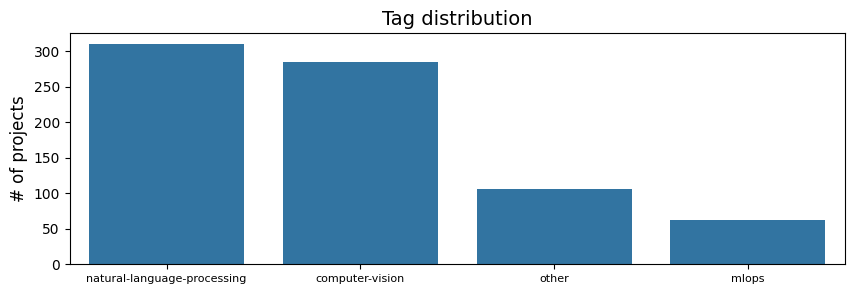

In [16]:
tags, tag_counts = zip(*Counter(df.tag).most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

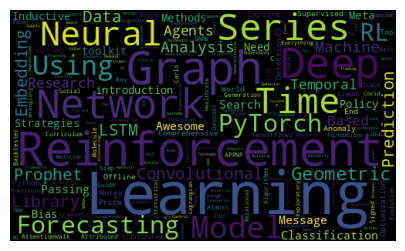

In [20]:
# Most frquent tokens
tag="other"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

### Preprocessing

In [5]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [6]:
df["text"] = df.title +" "+ df.description

In [7]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def clean_text(text, stopwords=STOPWORDS):
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    return text

def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [9]:
original_df = df.copy()
df.text = df.text.apply(clean_text)

In [10]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [11]:
# Label to index
tags = df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'other': 1,
 'natural-language-processing': 2,
 'mlops': 3}

In [12]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,0
1,show infer tell contextual inference creative ...,0
2,awesome graph classification collection import...,1
3,awesome monte carlo tree search curated list m...,1
4,attentionwalk pytorch implementation watch ste...,1


In [13]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizing

In [14]:
import numpy as np
from transformers import BertTokenizer

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [16]:
# Bert tokenizer wrapper
def tokenize(batch):
    # Converts the input text (a concat of title and description with the stopwords removed) into:
    # Token Ids
    # Binary Mask
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False) # use the bert trained on scientific papers
    encoded_inputs = tokenizer(batch['text'].tolist(), return_tensors="np", padding="longest") # pass in the text from the df, format as a numpy array
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"])) # format the values into a dictionary

In [17]:
tokenize(df.head(1))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}